# ЛР №3

## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

## 1) Импорт библиотек. Загрузка, первичный анализ и масштабирование данных.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from typing import Dict, Tuple
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split

В качестве набора данных мы будем использовать набор данных, [содержащий информацию о прогнозе смертности от сердечной недостаточности](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data)

Датасет состоит из одного файла:
'heart.csv'

In [3]:
data = pd.read_csv('data/heart.csv', sep=",")

In [4]:
# Размер датасета (строки, столбцы)
data.shape

(299, 13)

In [5]:
# Список колонок с типами данных
data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [6]:
# Количество пропущенных значений
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
# Первые 5 строк датасета
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Как видно, приведённый набор данных не имеет пропусков и все колонки имеют численный тип данных. Однако для успешного решения задачи классификации мы должны произвести масштабированние данных в колонках "platelets", "time" "serum_sodium" и "creatinine_phosphokinase".

In [8]:
data['time'] = MinMaxScaler().fit_transform(data[['time']])
data['platelets'] = MinMaxScaler().fit_transform(data[['platelets']])
data['serum_sodium'] = MinMaxScaler().fit_transform(data[['serum_sodium']])
data['creatinine_phosphokinase'] = MinMaxScaler().fit_transform(data[['creatinine_phosphokinase']])

In [9]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,0.071319,0,20,1,0.290823,1.9,0.485714,1,0,0.000000,1
1,55.0,0,1.000000,0,38,0,0.288833,1.1,0.657143,1,0,0.007117,1
2,65.0,0,0.015693,0,20,0,0.165960,1.3,0.457143,1,1,0.010676,1
3,50.0,1,0.011227,0,20,0,0.224148,1.9,0.685714,1,0,0.010676,1
4,65.0,1,0.017479,1,20,0,0.365984,2.7,0.085714,0,0,0.014235,1


Формируем целевой признак для классификации

In [10]:
def regr_to_class(y: int) -> str:
    if y==1:
        result = 'Died'
    else:
        result = 'Alive'        
    return result 

In [11]:
# формирование целевого признака для классификации
data['death_ev'] = \
data.apply(lambda row: regr_to_class(row['DEATH_EVENT']),axis=1)

In [12]:
data = data.drop(['DEATH_EVENT'], axis=1)

In [13]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_ev
0,75.0,0,0.071319,0,20,1,0.290823,1.9,0.485714,1,0,0.000000,Died
1,55.0,0,1.000000,0,38,0,0.288833,1.1,0.657143,1,0,0.007117,Died
2,65.0,0,0.015693,0,20,0,0.165960,1.3,0.457143,1,1,0.010676,Died
3,50.0,1,0.011227,0,20,0,0.224148,1.9,0.685714,1,0,0.010676,Died
4,65.0,1,0.017479,1,20,0,0.365984,2.7,0.085714,0,0,0.014235,Died


Датасет отмасштабирован и готов к решению задачи классификации

## 2) Разделение выборки на обучающую и тестовую.

In [14]:
parts = np.split(data, [12,13], axis=1)
X = parts[0]
Y = parts[1]
print('Входные данные:\n\n', X.head(), '\n\nВыходные данные:\n\n', Y.head())

Входные данные:

   age anaemia creatinine_phosphokinase diabetes ejection_fraction  \
0  75       0                0.0713192        0                20   
1  55       0                        1        0                38   
2  65       0                0.0156928        0                20   
3  50       1                0.0112274        0                20   
4  65       1                0.0174789        1                20   

  high_blood_pressure platelets serum_creatinine serum_sodium sex smoking  \
0                   1  0.290823              1.9     0.485714   1       0   
1                   0  0.288833              1.1     0.657143   1       0   
2                   0   0.16596              1.3     0.457143   1       1   
3                   0  0.224148              1.9     0.685714   1       0   
4                   0  0.365984              2.7    0.0857143   0       0   

         time  
0           0  
1  0.00711744  
2   0.0106762  
3   0.0106762  
4   0.0142349   

Выходн

In [15]:
Y=np.ravel(Y)

In [38]:
X_train,  X_test,  Y_train,  Y_test = train_test_split(X,  Y, test_size=0.1)

In [39]:
# Проверим правильность разделения выборки на тестовую и обучающую. Посмотрим на размеры матриц.
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(269, 12)
(30, 12)
(269,)
(30,)


In [40]:
Y_test=np.ravel(Y_test)

In [41]:
Y_train=np.ravel(Y_train)

## 3) Обучение модели ближайших соседей для произвольно заданного гиперпараметра K. Оценка качества модели.

In [42]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [43]:
# Решение задачи регрессии методом 5 ближайших соседей
Classifier_5 = KNeighborsClassifier(n_neighbors = 5)

In [44]:
Classifier_5.fit(X_train, Y_train)
target_5 = Classifier_5.predict(X_test)

print('Первые 5 предсказанных значения:\n\n', target_5[:5])

Первые 5 предсказанных значения:

 ['Died' 'Alive' 'Alive' 'Alive' 'Died']


In [45]:
print('Процент правильно определённых классов для 5 ближайших соседей:',accuracy_score(Y_test, target_5))

Процент правильно определённых классов для 5 ближайших соседей: 0.7


In [46]:
print_accuracy_score_for_classes(Y_test, target_5)

Метка 	 Accuracy
Alive 	 0.8888888888888888
Died 	 0.4166666666666667


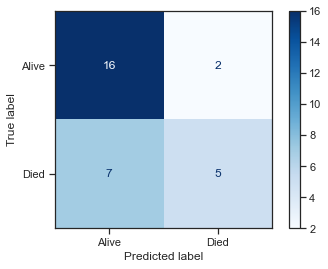

In [47]:
plot_confusion_matrix(Classifier_5, X_test, Y_test, 
                      display_labels=['Alive','Died'], cmap=plt.cm.Blues)

## 4) Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидация, Оценка качества оптимальной модели.

### Кросс-валидация

In [26]:
kf = KFold(n_splits=10)
scores = cross_validate(KNeighborsClassifier(n_neighbors=5), 
                        X, Y, scoring='accuracy', 
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.00999737, 0.0079999 , 0.00699496, 0.00799918, 0.00899935,
        0.00900054, 0.0090065 , 0.0080049 , 0.00799417, 0.00699401]),
 'score_time': array([0.01100206, 0.0109942 , 0.00899768, 0.00899911, 0.01000071,
        0.0079999 , 0.00899124, 0.00800109, 0.00900292, 0.00900626]),
 'test_score': array([0.4       , 0.46666667, 0.76666667, 0.73333333, 0.8       ,
        0.8       , 0.6       , 0.66666667, 0.8       , 0.89655172]),
 'train_score': array([0.79925651, 0.81412639, 0.79925651, 0.79925651, 0.77695167,
        0.78810409, 0.83271375, 0.80297398, 0.79182156, 0.78518519])}

In [27]:
kf1 = ShuffleSplit(n_splits=10, test_size=0.25)
scores1 = cross_validate(KNeighborsClassifier(n_neighbors=5), 
                        X, Y, scoring='accuracy', 
                        cv=kf1, return_train_score=True)
scores1

{'fit_time': array([0.01399851, 0.00599933, 0.00700498, 0.00799227, 0.0079999 ,
        0.00800323, 0.00800943, 0.        , 0.        , 0.01326561]),
 'score_time': array([0.01499796, 0.01300049, 0.01300025, 0.01300693, 0.01300621,
        0.01299477, 0.01199961, 0.01561999, 0.0145216 , 0.01300573]),
 'test_score': array([0.70666667, 0.77333333, 0.72      , 0.65333333, 0.70666667,
        0.73333333, 0.72      , 0.76      , 0.70666667, 0.66666667]),
 'train_score': array([0.81696429, 0.79910714, 0.80357143, 0.81696429, 0.80803571,
        0.80357143, 0.77678571, 0.79464286, 0.78125   , 0.80357143])}

In [28]:
kf2 = LeaveOneOut()

### Оптимизация гиперпараметров

#### K-Fold 

In [29]:
n_range = np.array(range(1, 101, 1))
tuned_parameters = [{'n_neighbors': n_range}]
gs1 = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf, scoring='accuracy')
gs1.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])}],
             scoring='accuracy')

In [30]:
print('Лучшая модель:\n\n', gs1.best_estimator_)
print('\nЛучшее число ближайших соседей:\n\n',gs1.best_params_) 
print('\nЛучший процент правильно предсказанных значений:\n\n',gs1.best_score_)

Лучшая модель:

 KNeighborsClassifier(n_neighbors=17)

Лучшее число ближайших соседей:

 {'n_neighbors': 17}

Лучший процент правильно предсказанных значений:

 0.7598850574712643


Изменение качества тестовой выборки в зависимости от кол-ва соседей:



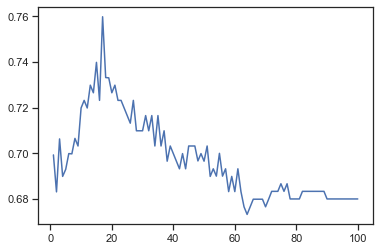

In [31]:
print('Изменение качества тестовой выборки в зависимости от кол-ва соседей:\n') 
plt.plot(n_range, gs1.cv_results_['mean_test_score'])

#### ShuffleSplit

In [32]:
gs2 = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf1, scoring='accuracy')
gs2.fit(X, Y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.25, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])}],
             scoring='accuracy')

In [33]:
print('Лучшая модель:\n\n', gs2.best_estimator_)
print('\nЛучшее число ближайших соседей:\n\n',gs2.best_params_) 
print('\nЛучший процент правильно предсказанных значений:\n\n',gs2.best_score_)

Лучшая модель:

 KNeighborsClassifier(n_neighbors=17)

Лучшее число ближайших соседей:

 {'n_neighbors': 17}

Лучший процент правильно предсказанных значений:

 0.7666666666666666


Изменение качества тестовой выборки в зависимости от кол-ва соседей:



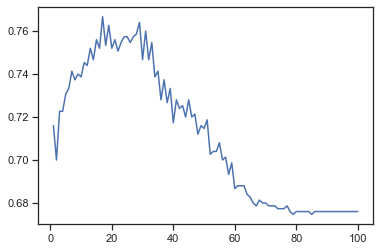

In [34]:
print('Изменение качества тестовой выборки в зависимости от кол-ва соседей:\n') 
plt.plot(n_range, gs2.cv_results_['mean_test_score'])

#### Leave one out

In [35]:
gs3 = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf2, scoring='accuracy')
gs3.fit(X, Y)

GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])}],
             scoring='accuracy')

In [36]:
print('Лучшая модель:\n\n', gs3.best_estimator_)
print('\nЛучшее число ближайших соседей:\n\n',gs3.best_params_) 
print('\nЛучший процент правильно предсказанных значений:\n\n',gs3.best_score_)

Лучшая модель:

 KNeighborsClassifier(n_neighbors=21)

Лучшее число ближайших соседей:

 {'n_neighbors': 21}

Лучший процент правильно предсказанных значений:

 0.7692307692307693


Изменение качества тестовой выборки в зависимости от кол-ва соседей:



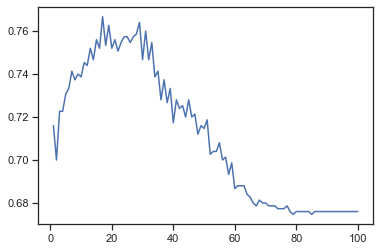

In [37]:
print('Изменение качества тестовой выборки в зависимости от кол-ва соседей:\n') 
plt.plot(n_range, gs2.cv_results_['mean_test_score'])